In [139]:
import pandas as pd
import seaborn as sns
import nltk
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
import string
import re
from collections import Counter


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hladn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hladn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hladn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [129]:
cwd = os.getcwd()
df = pd.read_csv( os.path.join(cwd, 'full_dataset_all_labels.csv'))
stop_words=set(stopwords.words('english') + list(string.punctuation))

In [ ]:
i=21750
print(df['text'].iloc[i])
#print(df['tokenized_text'].iloc[i])
df[df['text'].str.contains("<USER> that's not how it works")]

In [131]:
def print_some_texts(columns):
    text_idxs = [47, 7240, 7241, 8013, 14500, 16500, 16304, 18300,  21750, 34036, 45159, 71920]
    for i in text_idxs:
        for column in columns:
            print(df[column].iloc[i])
#print_some_texts(['text'])

def tokenize(text):
    #print(text)
    text = preprocess_text(text)
    #print(text)
    tokens = word_tokenize(text)
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation). (adapted from lab example)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens
    

def preprocess_text(text):
    text = re.sub(r"http\S+", " ", text)            # remove urls
    text = re.sub('<USER>', '', text)               # remove '<USER>' as there are some such strings as user or url is masked with this string
    text = re.sub('<URL>', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)           # Remove punctuations
    text = text.lower()                             # Convert to lowercase
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)#remove tags
    text = re.sub("(\\d|\\W)+"," ",text)            # remove special characters and digits
    return text
    
    
def stemming(tokens):
    stemmer = SnowballStemmer("english")
    stems = [stemmer.stem(token) for token in tokens if (token not in stop_words)]
    return stems

from nltk.stem import WordNetLemmatizer
def lemmatizing(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas

In [132]:
df['preprocessed_text']=df['text'].apply(preprocess_text)
df['tokenized_text']= df['text'].apply(tokenize) 
df['stems']= df['tokenized_text'].apply(stemming) 

In [133]:
print_some_texts(['text','preprocessed_text',  'tokenized_text', 'stems'])

oh no your fucking internet points you can spend literally fucking no where poor fucking boohoobaby go kill yourself
oh no your fucking internet points you can spend literally fucking no where poor fucking boohoobaby go kill yourself
['oh', 'no', 'your', 'fucking', 'internet', 'points', 'you', 'can', 'spend', 'literally', 'fucking', 'no', 'where', 'poor', 'fucking', 'boohoobaby', 'go', 'kill', 'yourself']
['oh', 'fuck', 'internet', 'point', 'spend', 'liter', 'fuck', 'poor', 'fuck', 'boohoobabi', 'go', 'kill']
@SirJadeja Look @ d sun ☀ shine during #ENGvsWI  Match. It's a total conspiracy against all other team.  #England choose their venue where #Rain chances r Zero. How come eng never faced Rain?  CBI shud intervene n investigate against #ICCCricketWorldCup2019  #ShameOnICC😡😡😡
 sirjadeja look d sun shine during engvswi match it s a total conspiracy against all other team england choose their venue where rain chances r zero how come eng never faced rain cbi shud intervene n investigate

In [167]:
def label_most_frequent_words(df, label, column, n_words = 10, visualise = False):
    all_words_list=df[df['label']==label][column].sum()
    all_words_count = dict(Counter(all_words_list))
    words_freq = [(word, all_words_count[word]) for word in all_words_count]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    if visualise:
        top_n_words_freq = words_freq[:n_words]
        x,y=map(list,zip(*top_n_words_freq))
        sns.barplot(x=y, y=x)
        
    #print(words_freq)
    return words_freq

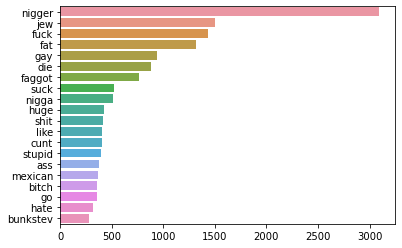

In [184]:
words_freq = label_most_frequent_words(df, label='identity_hate', column='stems', n_words = 20, visualise = True)
#print(words_freq)

In [161]:
#print(words_freq)